In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

/Users/jcolamendy/python/tutorials/ml-tutorials/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# imports
import numpy as np

import matplotlib.pyplot as plt

from keras import datasets
from keras import Input
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Lambda, Conv2D, MaxPooling2D, Flatten
from keras.metrics import binary_accuracy, BinaryAccuracy
from keras.ops import norm, cast, maximum, square

In [4]:
# function to create pairs of images for demonstration
def create_pairs(x, y):
    x_pairs = []
    y_pairs = []

    for i in range(len(x)):
        y_label = y[i]

        # Find a random sample representing the same label, for positive pair
        positive_indexes = np.where(y == y_label)[0]
        positive_index = np.random.choice(positive_indexes)
        x_pairs.append([x[i], x[positive_index]])
        # For positive pair, the ground truth label is 0
        y_pairs.append([0])

        # Find a random sample representing a different label, for negative pair
        negative_indexes = np.where(y != y_label)[0]
        negative_index = np.random.choice(negative_indexes)
        x_pairs.append([x[i], x[negative_index]])
        # For negative pair, the ground truth label is 1
        y_pairs.append([1])

    indexes = np.arange(len(x_pairs))
    np.random.shuffle(indexes)

    x_pairs = np.array(x_pairs)
    y_pairs = np.array(y_pairs)
    return x_pairs[indexes], y_pairs[indexes]

In [5]:
# load and preprocess the MNIST dataset as a placeholder
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [6]:
# normalize data
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

In [7]:
# create the pairs
x_train_pairs, y_train_pairs = create_pairs(x_train, y_train)
x_test_pairs, y_test_pairs = create_pairs(x_test, y_test)

In [8]:
# print out dimensions
print("Train pairs shape:", x_train_pairs.shape)
print("Train labels shape:", y_train_pairs.shape)

Train pairs shape: (120000, 2, 28, 28, 1)
Train labels shape: (120000, 1)


In [10]:
# display the pairs
def display_pairs(X, y, correct=None):
    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()

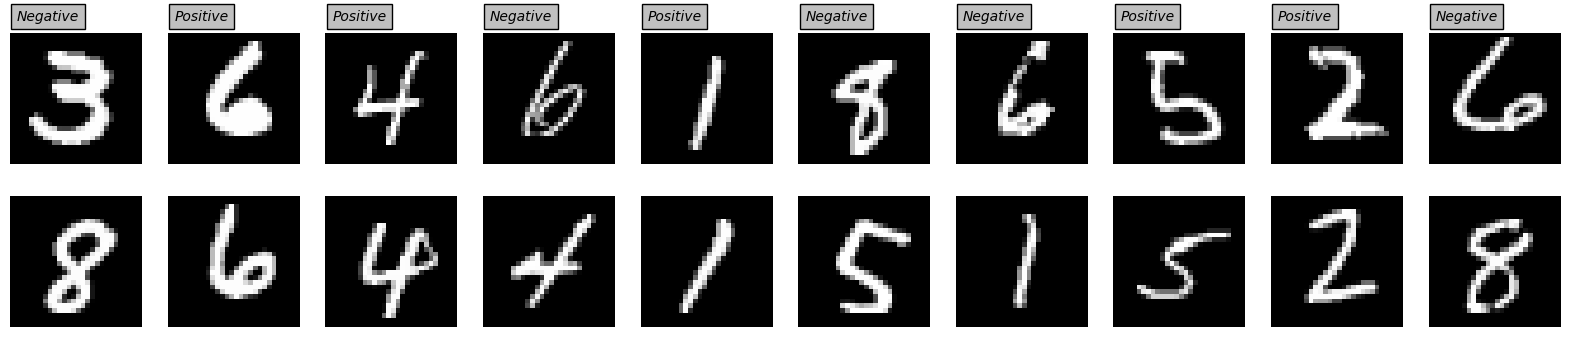

In [12]:
display_pairs(x_train_pairs, y_train_pairs)

In [14]:
# define model
def create_base_network(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model

input_shape = (28, 28, 1)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors
def euclidean_distance(processed):
    processed_a, processed_b = processed
    return norm(processed_a - processed_b, axis=1, keepdims=True)
# use lambda layer to compute the euclidean distance
distance = Lambda(euclidean_distance)([processed_a, processed_b])

# Define the model
model = Model(inputs=[input_a, input_b], outputs=distance)
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │    238,592 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 238,592 (932.00 KB)

 Trainable params: 238,592 (932.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# define the contrastive loss function
# y -> ground truth for the pairs. See above {0: images are similar, 1: images not similar}
# d -> distance calculated by the model
def contrastive_loss(y, d):
    margin = 1
    y = cast(y, d.dtype)
    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))
    return loss

# compile the model
model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [16]:
# Train the model
# train the model
history = model.fit([x_train_pairs[:, 0], x_train_pairs[:, 1]], y_train_pairs[:],
    validation_data=([x_test_pairs[:, 0], x_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32, epochs=10,
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - binary_accuracy: 0.9405 - loss: 0.0337 - val_binary_accuracy: 0.9856 - val_loss: 0.0127
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - binary_accuracy: 0.9886 - loss: 0.0093 - val_binary_accuracy: 0.9856 - val_loss: 0.0089
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - binary_accuracy: 0.9937 - loss: 0.0057 - val_binary_accuracy: 0.9865 - val_loss: 0.0076
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - binary_accuracy: 0.9955 - loss: 0.0039 - val_binary_accuracy: 0.9808 - val_loss: 0.0087
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - binary_accuracy: 0.9965 - loss: 0.0028 - val_binary_accuracy: 0.9837 - val_loss: 0.0073
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - binary_accuracy: 0.9971 - loss: 0.0023 - val_binary_accuracy: 0.9801 - val_loss: 0.0089
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - binary_accuracy: 0.9973 - loss: 0.0020 - val_binary_accuracy: 0.97

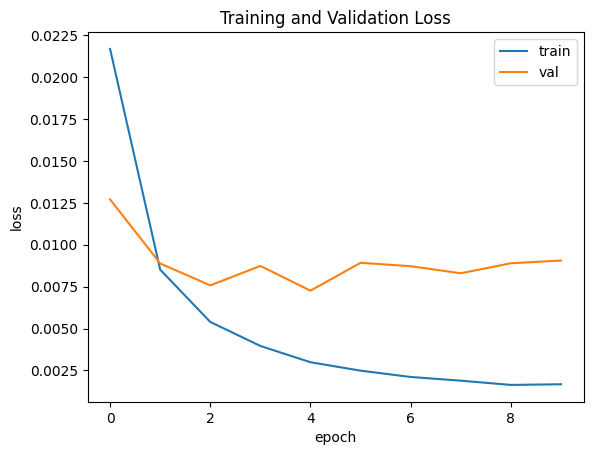

In [17]:
# plot the learning curve
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

In [19]:
# compute the accuracy of the model
accuracy = BinaryAccuracy()
predictions = model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]])
print(predictions[:10])
eval_predictions = predictions >= 0.5
print(eval_predictions[:10])
accuracy.update_state(y_test_pairs, eval_predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[0.02081955]
 [0.28769824]
 [0.04420187]
 [0.01886131]
 [0.03117761]
 [1.415266  ]
 [0.03597716]
 [0.01930298]
 [0.01261495]
 [1.4109415 ]]
[[False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]]
Accuracy: 0.98


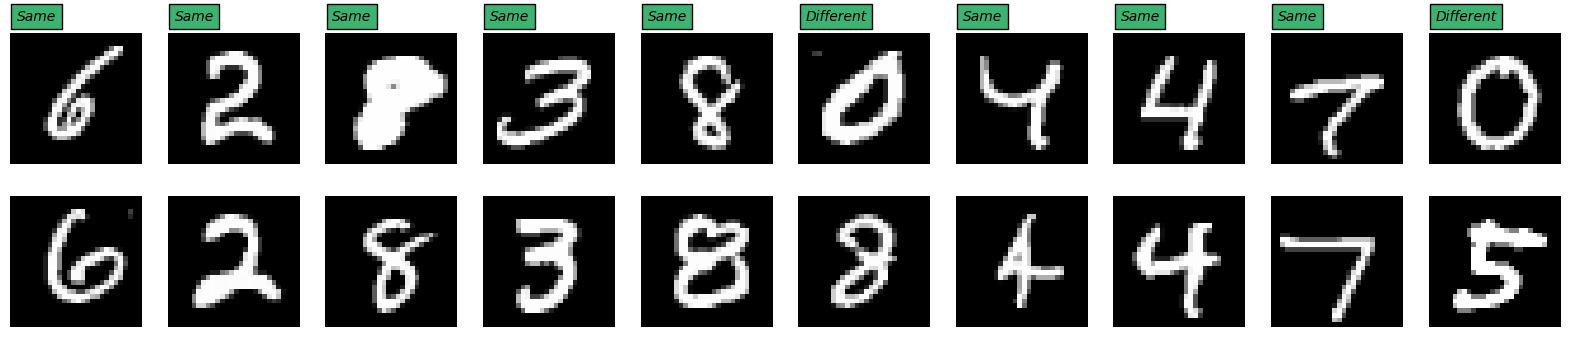

In [20]:
display_pairs(x_test_pairs, eval_predictions, eval_predictions == y_test_pairs)

In [21]:
embedding_model = model.layers[2]

In [28]:
# embedding for number 7
seven_indexes = np.where(y_test == 7)[0]
seven_index = np.random.choice(seven_indexes)
print(seven_index)
print(y_test[seven_index])
print(x_test[seven_index].shape)
seven_embedding = embedding_model.predict(x_test[seven_index].reshape(1, 28, 28, 1))
print(seven_embedding.shape)

8173
7
(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1, 128)


In [31]:
def classify_as_seven(label, threshold=0.5):
    indexes = np.where(y_test == label)[0]
    index = np.random.choice(indexes)
    embedding = embedding_model.predict(x_test[index].reshape(1, 28, 28, 1))
    # compute the distance
    d = norm(seven_embedding - embedding).numpy()
    print(d)
    if d < threshold:
        print('the same')
    else:
        print('not the same')

In [32]:
classify_as_seven(3)
classify_as_seven(7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1.3881463
not the same
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.02446097
the same
